# Quick start

Below scripts illustrates how to use different modules in [JAXIP](https://jax.readthedocs.io/).

## Initialization

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "1"       # enable double precision (float64)
os.environ["JAX_PLATFORM_NAME"] = "cpu"  # disable GPU-accelerated computing

## Imports

In [2]:
from jaxip.types import dtype as default_dtype
import jax.numpy as jnp
import jax

import numpy as np
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm

In [3]:
# default_dtype.FLOATX = jnp.float64    # set precision here (e.g. float32 or float64)

## Dataset

In [4]:
base_dir = Path('./H2O_2')

### RuNNer
Read [RuNNer](https://www.uni-goettingen.de/de/560580.html) data format

In [5]:
from jaxip.datasets import RunnerStructureDataset
structures = RunnerStructureDataset(Path(base_dir, "input.data"), persist=True)
print("Total number of structures:", len(structures))
structures

Total number of structures: 1593


RunnerStructureDataset(filename='H2O_2/input.data', transform=ToStructure())

In [6]:
structures = [structures[i] for i in range(10)]

### Data loader

In [7]:
# from torch.utils.data import DataLoader

#### Split train and validation structures

In [8]:
# import torch
# validation_split = 0.032
# nsamples = len(structures)
# split = int(np.floor(validation_split * nsamples))
# train_structures, valid_structures = torch.utils.data.random_split(structures, lengths=[nsamples-split, split])
# structures = valid_structures

## Structure

In [9]:
s = structures[0]
s

Structure(natoms=192, elements=('H', 'O'), dtype=float32)

In [10]:
from ase.visualize import view
atoms = s.to_ase_atoms()
view(atoms, viewer='x3d') # ase, ngl

In [11]:
from ase.io.vasp import write_vasp
write_vasp('POSCAR', atoms)

### Compare between structures

In [12]:
from jaxip.utils.compare import compare
compare(structures[0], structures[1])

Comparing two structures, error metrics: RMSEpa


{'force_RMSEpa': Array(0.06592743, dtype=float32),
 'energy_RMSEpa': Array(1.780192e-05, dtype=float32)}

### Calculate distance btween atoms

In [13]:
dis, _ = s.calculate_distance(atom_index=0)

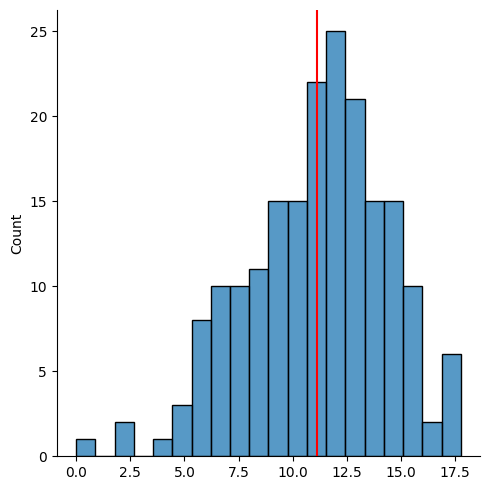

In [14]:
sns.displot(dis, bins=20)
plt.axvline(dis.mean(), color='r');

### Per-atom energy offset

In [15]:
# structure = structures[0]
# atom_energy = {'O': 2.4, 'H': 1.2}

# structure.add_energy_offset(atom_energy)
# structure.total_energy

## Descriptor

Atomic environment descriptor.

In [16]:
from jaxip.descriptors.acsf import ACSF, G2, G3, G9, CutoffFunction

In [17]:
# acsf = ACSF('Ne')
# cfn = CutoffFunction(3.0, cutoff_type='tanhu')
# acsf.add(G2(cfn, eta=1.00, r_shift=0.00), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.25), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.50), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=0.75), "Ne")
# acsf.add(G2(cfn, eta=1.00, r_shift=1.00), "Ne")

# acsf

In [18]:
acsf = ACSF('O')

cfn = CutoffFunction(12.0)
g2_1 = G2(cfn, 0.0, 0.001)
g2_2 = G2(cfn, 0.0, 0.01)
g3_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)
g9_1 = G3(cfn, 0.2, 1.0, 1.0, 0.0)

acsf.add(g2_1, 'H')
acsf.add(g2_2, 'H')
acsf.add(g3_1, 'H', 'H')
acsf.add(g3_1, 'H', 'O')
acsf.add(g9_1, 'H', 'O')
acsf

ACSF(element='O', num_symmetry_functions=5, r_cutoff=12.0)

### Computing descriptor values

In [19]:
%time val = acsf(s)
val[1, :]

CPU times: user 2.31 s, sys: 18.3 ms, total: 2.33 s
Wall time: 2.05 s


Array([6.2318468e+00, 4.6910887e+00, 2.6130967e-03, 2.2319485e-04,
       2.2319485e-04], dtype=float32)

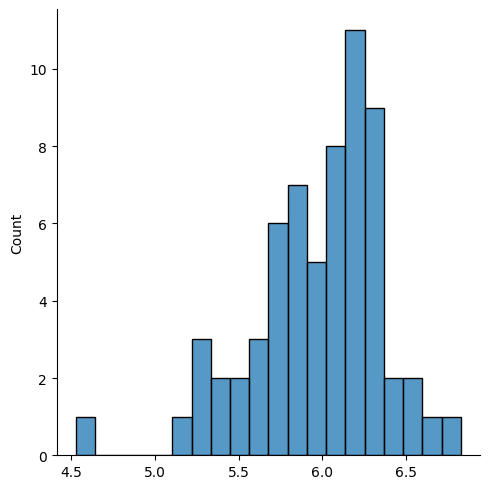

In [20]:
sns.displot(val[:, 0], bins=20);

### Gradient

In [21]:
%time acsf.grad(s, atom_index=0)

CPU times: user 2.35 s, sys: 16.8 ms, total: 2.36 s
Wall time: 2.29 s


Array([[-6.2721275e-02,  8.8095188e-02, -1.5681703e-01],
       [-4.6227857e-02,  9.1005132e-02, -1.3637491e-01],
       [ 8.9767032e-05, -3.3083491e-04,  4.0943902e-05],
       [-1.4203062e-04, -3.4254149e-06,  1.2955668e-05],
       [-1.4203062e-04, -3.4254149e-06,  1.2955668e-05]], dtype=float32)

## Scaler

Descriptor scaler.

In [22]:
from jaxip.descriptors.scaler import DescriptorScaler

### Fitting scaling parameters

In [23]:
scaler = DescriptorScaler(scale_type='scale_center')
# acsf = nnp.descriptor["H"]

for structure in tqdm(structures):
    x = acsf(structure)
    scaler.fit(x)

scaler

100%|██████████| 10/10 [00:00<00:00, 10.08it/s]


DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0)

In [24]:
scaled_x = []
for structure in tqdm(structures):
    x = acsf(structure)
    scaled_x.append(scaler(x))

scaled_x = jnp.concatenate(scaled_x, axis=0)
scaled_x.shape

100%|██████████| 10/10 [00:00<00:00, 10.50it/s]


(640, 5)

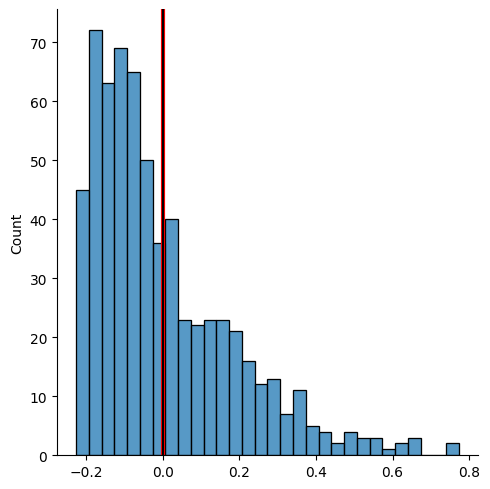

In [25]:
sx = scaled_x[:, 5]
sns.displot(sx, bins=30)
plt.axvline(sx.mean(), color='r', lw=3);
plt.axvline(0, color='k');

## Model

In [26]:
from jaxip.models.nn import NeuralNetworkModel
from jaxip.models.initializer import UniformInitializer
from flax import linen as nn

In [27]:
nn = NeuralNetworkModel(
    hidden_layers=((8, 'tanh'), (8, 'tanh')),
    kernel_initializer=UniformInitializer(weights_range=(-1, 1)),
    # param_dtype=jnp.float64,
)

nn

NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')), output_layer=(1, 'identity')

In [28]:
rng = jax.random.PRNGKey(2022)                       # PRNG Key
x = jnp.ones(shape=(8, acsf.num_symmetry_functions)) # Dummy Input
params = nn.init(rng, x)                             # Initialize the parameters
jax.tree_map(lambda x: x.shape, params)              # Check the parameters

FrozenDict({
    params: {
        layers_0: {
            bias: (8,),
            kernel: (5, 8),
        },
        layers_2: {
            bias: (8,),
            kernel: (8, 8),
        },
        layers_4: {
            bias: (1,),
            kernel: (8, 1),
        },
    },
})

### Computing output energy

In [29]:
energies = nn.apply(params, scaled_x[:, :])

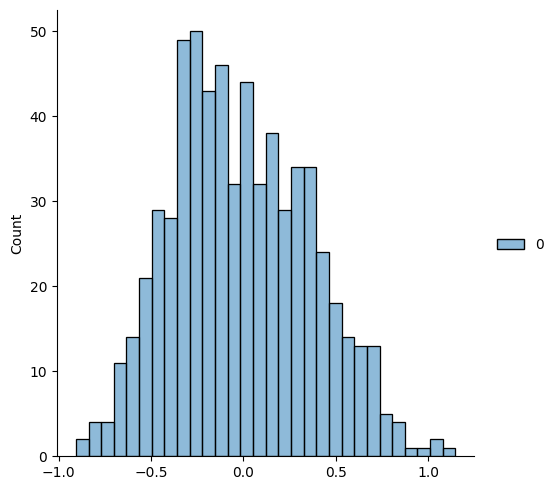

In [30]:
sns.displot(energies, bins=30);

## Atomic Potential

An atomic potential calculates the energy of a specific element in structures. It forms the basic building block of the final potential, which typically contains multiple elements. Atomic potential bundles up all the necessary components such as descriptors, scalers, and models in order to output the per-atomic energy.

In [31]:
from jaxip.potentials.nnp import AtomicPotential

In [32]:
atomic_potential = AtomicPotential(
    descriptor=acsf,
    scaler=scaler,
    model=nn,
)

atomic_potential

AtomicPotential(
  descriptor=ACSF(element='O', num_symmetry_functions=5, r_cutoff=12.0),
  scaler=DescriptorScaler(scale_type='scale_center', scale_min=0.0, scale_max=1.0),
  model=NeuralNetworkModel(hidden_layers=((8, 'tanh'), (8, 'tanh')), output_layer=(1, 'identity'),
)

In [33]:
out =  atomic_potential.apply(params["params"], s)
out.shape

(64, 1)

In [34]:
energies = []
for structure in tqdm(structures):
    out = atomic_potential.apply(params['params'], structure)
    energies.append(out)

energies = jnp.concatenate(energies, axis=0)
energies.shape

100%|██████████| 10/10 [00:00<00:00, 11.14it/s]


(640, 1)

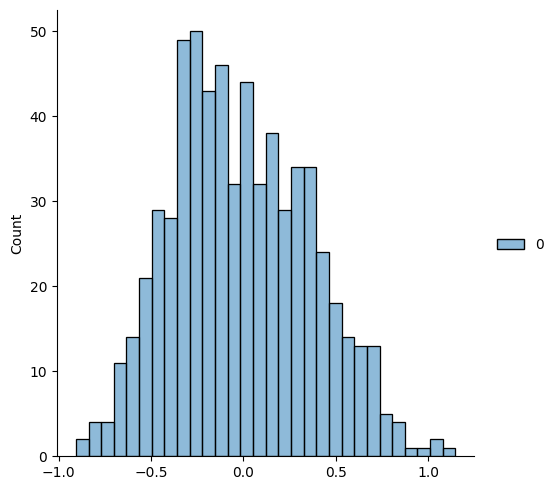

In [35]:
sns.displot(energies, bins=30);

Please note that the above graph is exactly the same graph as we obtained before by using the model.